### Well located events at Mt. Baker

- This notebook is the tutorial for `../src/python/well_located_events.py`
- The module modifies the original dataset `data/Events/Mt_Baker_50km_radius_origins.csv` based on the following criteria: 
        
1. 6+ observations (P or S wave picks): nobs >= 6

2. 4+ observing stations: nsta >= 4

3. no fixed values (depth, epicenter, or time): ['fdepth', 'fepi', 'ftime'] are set to False

4. a minimum observing station distance of no more than 10 km: distance <= 10

5. horizontal and vertical errors of 10 km or less: erhor & sdep <= 10

6. travel time RMS misfit of no more than 1 second: wrms <= 1
        
- The output is the modified dataset (well-located events at Mt. Baker)

In [1]:
# import necessary dependencies
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy import read
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client

sys.path.append(os.path.join('..','..','src','python'))

from well_located_events import *
from util import *

#### Step 1: clean the datasets
- Rename the columns
- Leap year correction and time converting to UTC
- Boolean correction

In [2]:
# define the relative root directory path
rrpath = os.path.join('..', '..')

In [3]:
# clean the original dataset
input_file1 = 'MtBaker_50km_radius_origins.csv'
cleaned_df = prep_data(input_file1)

#### Step 2: Curate the well-located events at Mt. Baker
- Refer to the above criteria

In [4]:
# curate the well-located events
input_file2 = cleaned_df
curate_df = curate_events(input_file2)

#### Step 3: Visualization

In [5]:
# convert to datetime object
cleaned_df['origin_datetime'] = cleaned_df['origin_datetime'].apply(lambda x: x.isoformat())
cleaned_df['origin_datetime'] = pd.to_datetime(cleaned_df['origin_datetime'])

curate_df['origin_datetime'] = curate_df['origin_datetime'].apply(lambda x: x.isoformat())
curate_df['origin_datetime'] = pd.to_datetime(curate_df['origin_datetime'])

/var/folders/pf/3_nyp_6j7059y5qxp6tr1_vm0000gn/T/ipykernel_16310/2255489258.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curate_df['origin_datetime'] = curate_df['origin_datetime'].apply(lambda x: x.isoformat())
/var/folders/pf/3_nyp_6j7059y5qxp6tr1_vm0000gn/T/ipykernel_16310/2255489258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curate_df['origin_datetime'] = pd.to_datetime(curate_df['origin_datetime'])


In [6]:
# create a new dataframe with a multi-index
cleaned_df_multi_index = cleaned_df.set_index(['etype', 'origin_datetime'])
curated_df_multi_index = curate_df.set_index(['etype', 'origin_datetime'])

In [7]:
# display event types
event_types = cleaned_df_multi_index.index.get_level_values('etype').unique()
event_types

Index(['eq', 'uk', 'px', 'lf', 'ex', 'su'], dtype='object', name='etype')

In [8]:
# event types that have data in curated dataset; other event types have no data for curated dataset.
specific_event_types = ['eq', 'lf']

# boundaries for plotting
depth_min = cleaned_df_multi_index['depth'].min()
depth_max = cleaned_df_multi_index['depth'].max()

distance_km_min = cleaned_df_multi_index['distance'].min()
distance_km_max = cleaned_df_multi_index['distance'].max()

magnitude_min = cleaned_df_multi_index['magnitude'].min()
magnitude_max = cleaned_df_multi_index['magnitude'].max()

time_min = cleaned_df_multi_index.index.get_level_values('origin_datetime').min()
time_max = cleaned_df_multi_index.index.get_level_values('origin_datetime').max()

nobs_min = cleaned_df_multi_index['nobs'].min()
nobs_max = cleaned_df_multi_index['nobs'].max()

nsta_min = cleaned_df_multi_index['nsta'].min()
nsta_max = cleaned_df_multi_index['nsta'].max()

erhor_min = cleaned_df_multi_index['erhor'].min()
erhor_max = cleaned_df_multi_index['erhor'].max()

sdep_min = cleaned_df_multi_index['sdep'].min()
sdep_max = cleaned_df_multi_index['sdep'].max()

wrms_min = cleaned_df_multi_index['wrms'].min()
wrms_max = cleaned_df_multi_index['wrms'].max()


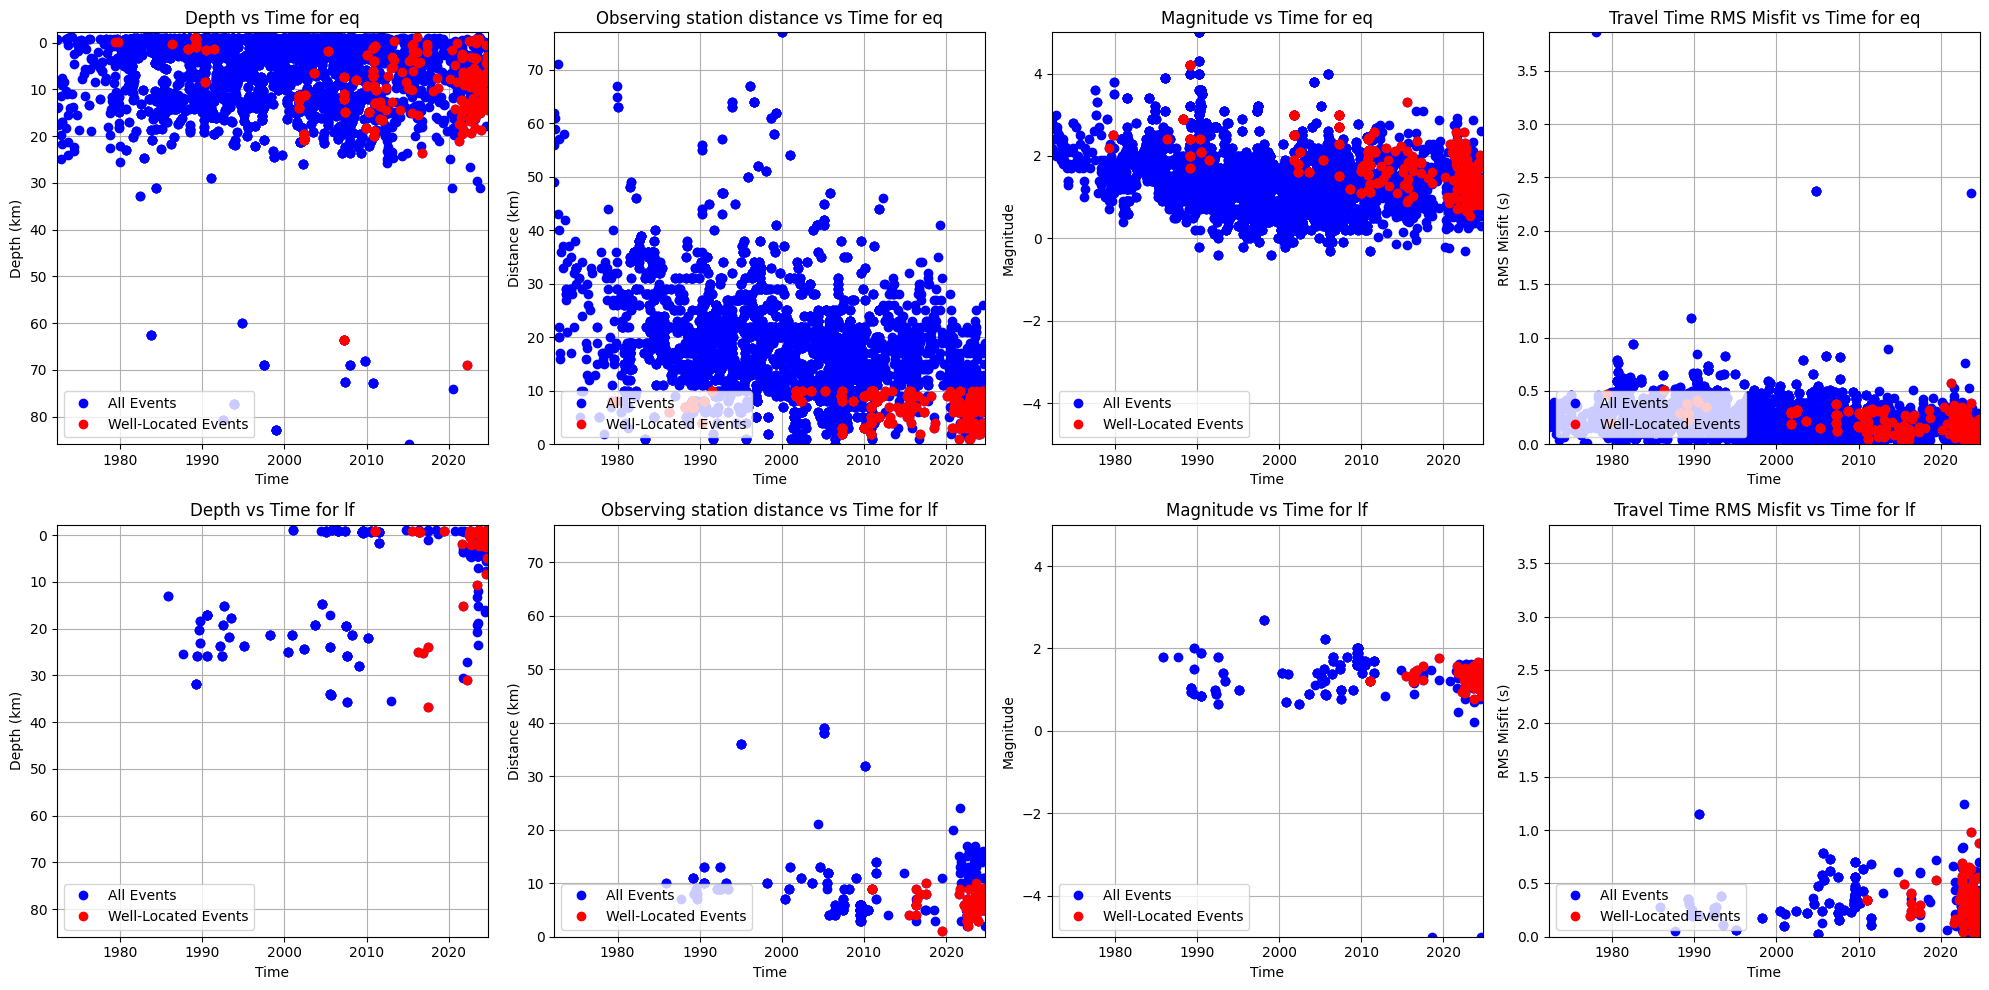

In [9]:
# create subplots
fig, axs = plt.subplots(nrows=len(specific_event_types), ncols=4, figsize=(20, 5 * len(specific_event_types)))

for i, etype in enumerate(specific_event_types):

    subset1 = cleaned_df_multi_index.xs(etype, level='etype')  # xs() is cross-section. It is used to retrieve data at a specific level of a MultiIndex.
    subset2 = curated_df_multi_index.xs(etype, level='etype')

    # scatter plot for depth
    axs[i, 0].plot(subset1.index, subset1['depth'], 'bo', label='All Events')  
    axs[i, 0].plot(subset2.index, subset2['depth'], 'ro', label='Well-Located Events')  
    axs[i, 0].set_title(f'Depth vs Time for {etype}')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Depth (km)')
    axs[i, 0].set_ylim(depth_min, depth_max)
    axs[i, 0].set_xlim(time_min, time_max)
    axs[i, 0].invert_yaxis()
    axs[i, 0].grid(True)
    axs[i, 0].legend(loc='lower left')

    # scatter plot for observing station distance
    axs[i, 1].plot(subset1.index, subset1['distance'], 'bo', label='All Events')
    axs[i, 1].plot(subset2.index, subset2['distance'], 'ro', label='Well-Located Events')
    axs[i, 1].set_title(f'Observing station distance vs Time for {etype}')
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].set_ylabel('Distance (km)')
    axs[i, 1].set_ylim(distance_km_min, distance_km_max)
    axs[i, 1].set_xlim(time_min, time_max)
    axs[i, 1].grid(True)
    axs[i, 1].legend(loc='lower left')

    # scatter plot for magnitude
    axs[i, 2].plot(subset1.index, subset1['magnitude'], 'bo', label='All Events')
    axs[i, 2].plot(subset2.index, subset2['magnitude'], 'ro', label='Well-Located Events')
    axs[i, 2].set_title(f'Magnitude vs Time for {etype}')
    axs[i, 2].set_xlabel('Time')
    axs[i, 2].set_ylabel('Magnitude')
    axs[i, 2].set_ylim(magnitude_min, magnitude_max)
    axs[i, 2].set_xlim(time_min, time_max)
    axs[i, 2].grid(True)
    axs[i, 2].legend(loc='lower left')

    # Scatter plot for travel time RMS misfit (wrms)
    axs[i, 3].plot(subset1.index, subset1['wrms'], 'bo', label='All Events')
    axs[i, 3].plot(subset2.index, subset2['wrms'], 'ro', label='Well-Located Events')
    axs[i, 3].set_title(f'Travel Time RMS Misfit vs Time for {etype}')
    axs[i, 3].set_xlabel('Time')
    axs[i, 3].set_ylabel('RMS Misfit (s)')
    axs[i, 3].set_ylim(wrms_min, wrms_max)
    axs[i, 3].set_xlim(time_min, time_max)
    axs[i, 3].grid(True)
    axs[i, 3].legend(loc='lower left')

plt.tight_layout()
plt.show()

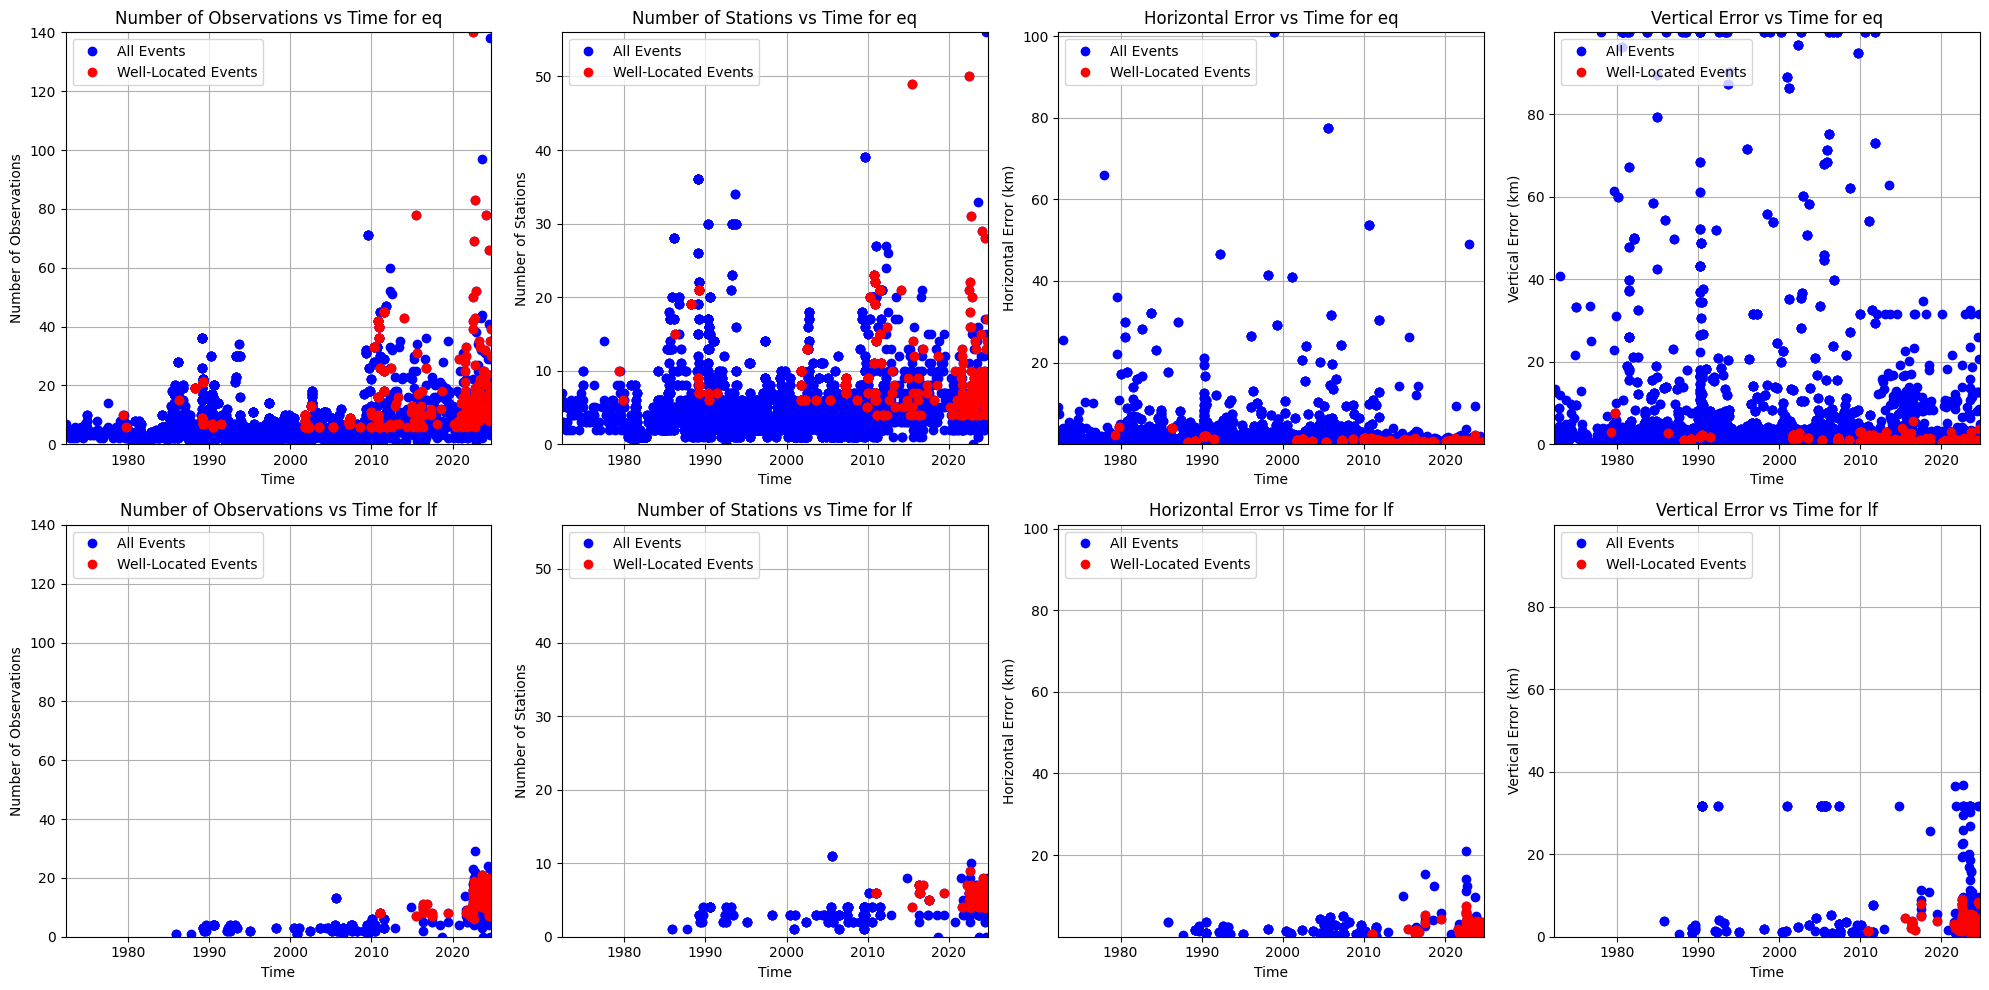

In [10]:
# create subplots
fig, axs = plt.subplots(nrows=len(specific_event_types), ncols=4, figsize=(20, 5 * len(specific_event_types)))

for i, etype in enumerate(specific_event_types):

    subset1 = cleaned_df_multi_index.xs(etype, level='etype')  # xs() is cross-section. It is used to retrieve data at a specific level of a MultiIndex.
    subset2 = curated_df_multi_index.xs(etype, level='etype')

    # scatter plot for number of observations (nobs)
    axs[i, 0].plot(subset1.index, subset1['nobs'], 'bo', label='All Events')
    axs[i, 0].plot(subset2.index, subset2['nobs'], 'ro', label='Well-Located Events')
    axs[i, 0].set_title(f'Number of Observations vs Time for {etype}')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Number of Observations')
    axs[i, 0].set_ylim(nobs_min, nobs_max)
    axs[i, 0].set_xlim(time_min, time_max)
    axs[i, 0].grid(True)
    axs[i, 0].legend(loc='upper left')

    # Scatter plot for number of stations (nsta)
    axs[i, 1].plot(subset1.index, subset1['nsta'], 'bo', label='All Events')
    axs[i, 1].plot(subset2.index, subset2['nsta'], 'ro', label='Well-Located Events')
    axs[i, 1].set_title(f'Number of Stations vs Time for {etype}')
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].set_ylabel('Number of Stations')
    axs[i, 1].set_ylim(nsta_min, nsta_max)
    axs[i, 1].set_xlim(time_min, time_max)
    axs[i, 1].grid(True)
    axs[i, 1].legend(loc='upper left')

    # Scatter plot for horizontal error (erhor)
    axs[i, 2].plot(subset1.index, subset1['erhor'], 'bo', label='All Events')
    axs[i, 2].plot(subset2.index, subset2['erhor'], 'ro', label='Well-Located Events')
    axs[i, 2].set_title(f'Horizontal Error vs Time for {etype}')
    axs[i, 2].set_xlabel('Time')
    axs[i, 2].set_ylabel('Horizontal Error (km)')
    axs[i, 2].set_ylim(erhor_min, erhor_max)
    axs[i, 2].set_xlim(time_min, time_max)
    axs[i, 2].grid(True)
    axs[i, 2].legend(loc='upper left')

    # Scatter plot for vertical error (sdep)
    axs[i, 3].plot(subset1.index, subset1['sdep'], 'bo', label='All Events')
    axs[i, 3].plot(subset2.index, subset2['sdep'], 'ro', label='Well-Located Events')
    axs[i, 3].set_title(f'Vertical Error vs Time for {etype}')
    axs[i, 3].set_xlabel('Time')
    axs[i, 3].set_ylabel('Vertical Error (km)')
    axs[i, 3].set_ylim(sdep_min, sdep_max)
    axs[i, 3].set_xlim(time_min, time_max)
    axs[i, 3].grid(True)
    axs[i, 3].legend(loc='upper left')

plt.tight_layout()
plt.show()

#### Step 4: Observation from the curated data

1. After filtering, only earthquakes (EQ) and low-frequency seismic events (LF) show data for all parameters, as these constitute the majority of events at Mt. Baker.

2. Well-located earthquake events are primarily found at shallow depths, typically up to 20 km, and are most prevalent after the year 2000. In contrast, well-located low-frequency events are mostly detected after 2010, with many clustering at very shallow depths, up to 10 km.

3. Well-located earthquake events are increasingly detected after 2000, while well-located low-frequency events have become more common since 2010, indicating a rise in such occurrences recently.

4. Both types of events exhibit low magnitudes, primarily clustered between 0 and 2.

5. For travel time RMS misfit, both event types show small misfits of less than 0.5 seconds. Additionally, clusters of well-located low-frequency events have been more frequently identified after 2020, suggesting improvements in modeling.

6. The number of observations and observing stations has increased over time, with well-located low-frequency events becoming more dominant after 2020, indicating enhanced detectability.

7. Both horizontal and vertical errors have decreased over time.